In [1]:
import os

import matplotlib
import torch
import torchvision
from jedi.api.refactoring import inline
from torch import nn
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn.functional as F

import mobilevit
import torch
import time
from einops import rearrange

In [2]:
class ImageClassificationBase(nn.Module):
	def training_step(self, batch):
		images, labels = batch
		out = self(images)  # Generate predictions
		loss = F.cross_entropy(out, labels)  # Calculate loss
		return loss

	def validation_step(self, batch):
		images, labels = batch
		out = self(images)  # Generate predictions
		loss = F.cross_entropy(out, labels)  # Calculate loss
		acc = accuracy(out, labels)  # Calculate accuracy
		return {'val_loss': loss.detach(), 'val_acc': acc}

	def validation_epoch_end(self, outputs):
		batch_losses = [x['val_loss'] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
		batch_accs = [x['val_acc'] for x in outputs]
		epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
		return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

	def epoch_end(self, epoch, result):
		print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
			epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))

In [3]:
data_dir = 'laji/Garbage_classification/Garbage_classification'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [5]:
import matplotlib.pyplot as plt


def show_sample(img, label,a):
    print("Label:",dataset.classes[label], "(Class No: " + str(label) + ")"+a)
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)Usually
Label: cardboard (Class No: 0)RandomHorizontalFlip


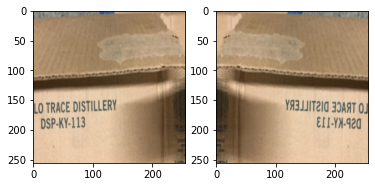

In [6]:
transformations = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.ToTensor()
                                     ])
dataset = ImageFolder(data_dir, transform=transformations)
img, label = dataset[12]
plt.subplot(1,2,1)
a='Usually'
show_sample(img, label,a)
transformations = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(0.5)
                                     ])
dataset = ImageFolder(data_dir, transform=transformations)
img, label =dataset[12]
plt.subplot(1,2,2)
a='RandomHorizontalFlip'
show_sample(img, label,a)

In [7]:
from timm.models.mobilevit import mobilevit_s
from torch import nn, optim

In [8]:
class Mobilevit(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = mobilevit_s(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.head.fc.in_features
        self.network.head.fc = nn.Linear(num_ftrs, 6)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = Mobilevit()

In [9]:
random_seed = 42
torch.manual_seed(random_seed)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(val_ds),len(dataset)

(2021, 506, 2527)

In [13]:
from torch.utils.data.dataloader import DataLoader

batch_size = 8

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=False)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=False)

In [14]:
from torchvision.utils import make_grid
def show_batch(dl):
	for images, labels in dl:
		fig, ax = plt.subplots(figsize=(12, 6))
		ax.set_xticks([])
		ax.set_yticks([])
		ax.imshow(make_grid(images, nrow=4, ).permute(1, 2, 0))
		break

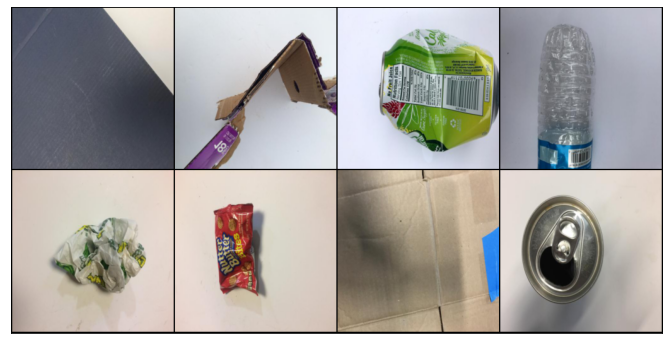

In [16]:
show_batch(val_dl)

In [13]:
def accuracy(outputs, labels):
	_, preds = torch.max(outputs, dim=1)
	return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [16]:
def evaluate(model, val_loader):
	model.eval()
	outputs = [model.validation_step(batch) for batch in val_loader]
	return model.validation_epoch_end(outputs)

In [17]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=50)
    epoch = 0
    best_acc = 0
    for aepoch in range(epoch, epoch + epochs):
        since = time.time()
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        scheduler.step()
        print("Lr:{:.2E}".format(optimizer.state_dict()['param_groups'][0]['lr']))
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(aepoch, result)
        if best_acc < result['val_acc']:
            best_acc = result['val_acc']
            torch.save(model.state_dict(), 'models/Mobilevit.pth')
            print("Copied best model weights!")
        history.append(result)
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return history

In [18]:
model = to_device(Mobilevit(), device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 5.5e-5

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
evaluate(model, val_dl)

{'val_loss': 1.7890205383300781, 'val_acc': 0.18084464967250824}

In [20]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Lr:5.49E-05
Epoch 1: train_loss: 1.7584, val_loss: 1.7073, val_acc: 0.6551
Copied best model weights!
Training complete in 0m 12s
Lr:5.48E-05
Epoch 2: train_loss: 1.6339, val_loss: 1.5515, val_acc: 0.7540
Copied best model weights!
Training complete in 0m 12s
Lr:5.45E-05
Epoch 3: train_loss: 1.4957, val_loss: 1.4372, val_acc: 0.7854
Copied best model weights!
Training complete in 0m 12s
Lr:5.41E-05
Epoch 4: train_loss: 1.4078, val_loss: 1.3759, val_acc: 0.8103
Copied best model weights!
Training complete in 0m 12s
Lr:5.37E-05
Epoch 5: train_loss: 1.3517, val_loss: 1.3254, val_acc: 0.8596
Copied best model weights!
Training complete in 0m 12s
Lr:5.31E-05
Epoch 6: train_loss: 1.3060, val_loss: 1.3035, val_acc: 0.8641
Copied best model weights!
Training complete in 0m 11s
Lr:5.24E-05
Epoch 7: train_loss: 1.2711, val_loss: 1.2694, val_acc: 0.8910
Copied best model weights!
Training complete in 0m 12s
Lr:5.16E-05
Epoch 8: train_loss: 1.2473, val_loss: 1.2331, val_acc: 0.9109
Copied best mod

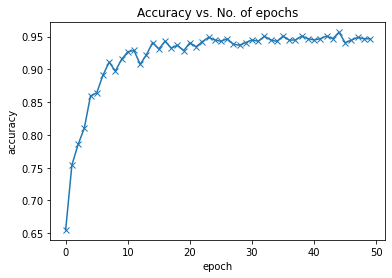

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

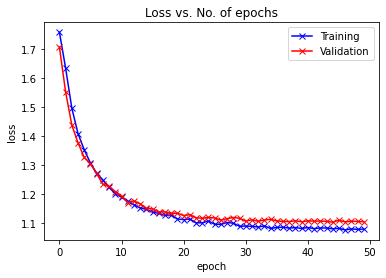

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [23]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


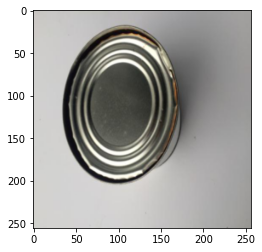

In [24]:
img, label = val_ds[228]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [25]:
torch.load('models/Mobilevit.pth',map_location=torch.device('cpu'))
model.eval()

Mobilevit(
  (network): ByobNet(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
  

In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: plastic , Predicted: plastic


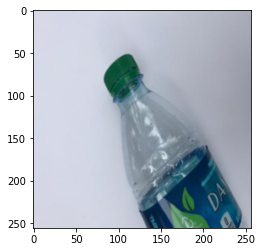

In [27]:
img, label = val_ds[347]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [28]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))
    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    a=predict_image(example_image, model)
    return a
    print("The image resembles",predict_image(example_image, model) + ".")

'paper'

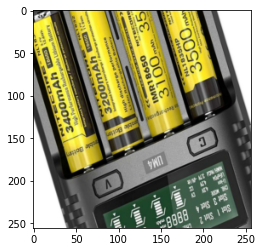

In [29]:
predict_external_image('garbage/harmful6.jpg')

In [30]:
model.load_state_dict(torch.load("model/Mobilevit.pth"))
# model = torchvision.models.mobilenet_v3_small(pretrained=True)
model.eval()
example = torch.rand(1, 3, 256, 256)
traced_script_module = torch.jit.trace(model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("model/mvt.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'model/Mobilevit.pth'